# Preparing mortality data.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Loading data

In [14]:
df_base = pd.read_csv('data/output/df_base_without_missing_points.csv', index_col=0)

In [15]:
df_base.columns

Index(['code_municipality_7', 'municipality', 'population', 'latitude',
       'longitude', 'percentage_population_age_range_0_19',
       'percentage_population_age_range_20_39',
       'percentage_population_age_range_40_59',
       'percentage_population_age_range_60_more',
       'percentage_urban_population', 'demographic_density',
       'average_residents_per_households',
       'percentage_population_in_households_more_2_residents_per_bedroom',
       'percentage_male_population', 'percentage_indigenous_population',
       'percentage_black_and_brown_population', 'life_expectancy_at_birth',
       'per_capita_income', 'gini', 'per_capita_cash_transfer_program',
       'percentage_estimated_households_in_informal_settlements',
       'percentage_population_in_informal_settlements',
       'demographic_density_in_informal_settlements',
       'percentage_population_in_households_without_bathroom',
       'percentage_hospitalizations_diseases_inadequate_sanitation',
       'activi

In [16]:
df_base['code_municipality_6'] = df_base['code_municipality_7'].astype('str').str[:6].astype('int64')

In [17]:
df_base = df_base[['code_municipality_6', 'code_municipality_7','population']].copy()

In [18]:
df_municipalities = pd.read_csv('data/input/df_sim_municipal.csv')

In [19]:
df_municipalities = pd.read_csv('data/input/df_sim_municipal.csv')[['DATA','CODIGO_MUNICIPIO_6','REGIAO','OBITOS','OBITOS_NOVOS']]
df_municipalities.columns = ['date', 'code_municipality_6', 'region', 'deaths', 'new_deaths']
df_municipalities.date = pd.to_datetime(df_municipalities.date)
df_municipalities = df_municipalities.sort_values('date')

In [20]:
df_municipalities.loc[df_municipalities['region']=='Nordeste', 'region'] = 'Northeast'
df_municipalities.loc[df_municipalities['region']=='Sudeste', 'region'] = 'Southeast'
df_municipalities.loc[df_municipalities['region']=='Sul', 'region'] = 'South'
df_municipalities.loc[df_municipalities['region']=='Norte', 'region'] = 'North'
df_municipalities.loc[df_municipalities['region']=='Centro-Oeste', 'region'] = 'Midwestern'

## Summary deaths by years

In [21]:
END_FIRST_SEMESTER_2020 = datetime.fromisoformat('2020-06-30')
END_2020 = datetime.fromisoformat('2020-12-31')
END_2021 = datetime.fromisoformat('2021-12-31')
END_2022 = datetime.fromisoformat('2022-12-31')

In [22]:
df_municipalities_end_study = df_municipalities[df_municipalities.date == END_2022].dropna().copy()

In [23]:
df_mortality = df_base.merge(df_municipalities_end_study, how='left', left_on='code_municipality_6', right_on='code_municipality_6')
df_mortality.index = df_base.index
df_mortality.deaths = df_mortality.deaths.fillna(0)

In [24]:
df_municipalities

,date,code_municipality_6,region,deaths,new_deaths
0,2020-03-12,260790,Northeast,1,1
3712,2020-03-12,250300,Northeast,0,0
3711,2020-03-12,220260,Northeast,0,0
3710,2020-03-12,410380,South,0,0
3709,2020-03-12,240350,Northeast,0,0
...,...,...,...,...,...
5697338,2022-12-31,260790,Northeast,2278,0
5697337,2022-12-31,260392,Northeast,12,0
5697336,2022-12-31,270642,Northeast,18,0
5697344,2022-12-31,420290,South,349,0


In [25]:
END_2022.strftime('%Y-%m-%d')

'2022-12-31'

In [26]:
for moment, column in zip([END_FIRST_SEMESTER_2020, END_2020, END_2021], ['deaths_accumulated_first_semester_2020', 'deaths_accumulated_2020', 'deaths_accumulated_2021']):
    df = df_municipalities[df_municipalities.date == moment].dropna().copy()
    df = df.rename(columns = {'deaths': column})
    df_mortality = df_mortality.merge(df[['code_municipality_6', column]], how='left', left_on='code_municipality_6', right_on='code_municipality_6')
    df_mortality.index = df_base.index
    df_mortality[column] = df_mortality[column].fillna(0)
    
    if (moment ==  END_FIRST_SEMESTER_2020) or (moment == END_2020):
        df_period = df_municipalities.loc[df_municipalities['date']<=moment]
    else:
        df_period = df_municipalities.loc[(df_municipalities['date']>END_2020) & (df_municipalities['date']<=moment)]
    df_period = df_period.loc[df_period['new_deaths']>0]
    df_date_first_death = df_period.groupby('code_municipality_6')['date'].min().reset_index()
    column_delta_first_death = 'delta_first_death_'+moment.strftime('%Y-%m-%d') 
    df_date_first_death[column_delta_first_death] = (moment - df_date_first_death['date']).dt.days
    df_mortality = df_mortality.merge(df_date_first_death[['code_municipality_6',column_delta_first_death]], how='left', left_on='code_municipality_6', right_on='code_municipality_6')
    df_mortality.index = df_base.index
    df_mortality[column_delta_first_death] = df_mortality[column_delta_first_death].fillna(0)

In [27]:
df_period = df_municipalities.loc[(df_municipalities['date']>END_2021) & (df_municipalities['date']<=END_2022)]
df_period = df_period.loc[df_period['new_deaths']>0]
df_date_first_death = df_period.groupby('code_municipality_6')['date'].min().reset_index()
column_delta_first_death = 'delta_first_death_'+END_2022.strftime('%Y-%m-%d') 
df_date_first_death[column_delta_first_death] = (END_2022 - df_date_first_death['date']).dt.days
df_mortality = df_mortality.merge(df_date_first_death[['code_municipality_6',column_delta_first_death]], how='left', left_on='code_municipality_6', right_on='code_municipality_6')
df_mortality.index = df_base.index
df_mortality[column_delta_first_death] = df_mortality[column_delta_first_death].fillna(0)

In [28]:
df_period = df_municipalities.loc[(df_municipalities['date']<=END_2022)]
df_period = df_period.loc[df_period['new_deaths']>0]
df_date_first_death = df_period.groupby('code_municipality_6')['date'].min().reset_index()
column_delta_first_death = 'delta_first_death_general_period' 
df_date_first_death[column_delta_first_death] = (END_2022 - df_date_first_death['date']).dt.days
df_mortality = df_mortality.merge(df_date_first_death[['code_municipality_6',column_delta_first_death]], how='left', left_on='code_municipality_6', right_on='code_municipality_6')
df_mortality.index = df_base.index
df_mortality[column_delta_first_death] = df_mortality[column_delta_first_death].fillna(0)

In [29]:
df_mortality['death_rate_accumulated_first_semester_2020'] = df_mortality['deaths_accumulated_first_semester_2020'] / df_mortality['population'] * 100000
df_mortality['death_rate_accumulated_2020'] = df_mortality['deaths_accumulated_2020'] / df_mortality['population'] * 100000
df_mortality['death_rate_accumulated_2021'] = df_mortality['deaths_accumulated_2021'] / df_mortality['population'] * 100000
df_mortality['death_rate_accumulated'] = df_mortality['deaths'] / df_mortality['population'] * 100000

In [30]:
df_mortality['death_rate_2022'] = df_mortality['death_rate_accumulated'] - df_mortality['death_rate_accumulated_2021']
df_mortality['death_rate_2021'] = df_mortality['death_rate_accumulated_2021'] - df_mortality['death_rate_accumulated_2020']
df_mortality['death_rate_2020'] = df_mortality['death_rate_accumulated_2020']
df_mortality['death_rate_first_semester_2020'] = df_mortality['death_rate_accumulated_first_semester_2020']

In [31]:
df_mortality['deaths_2022'] = df_mortality['deaths'] - df_mortality['deaths_accumulated_2021']
df_mortality['deaths_2021'] = df_mortality['deaths_accumulated_2021'] - df_mortality['deaths_accumulated_2020']

In [32]:
df_mortality[['death_rate_first_semester_2020','death_rate_2020', 'death_rate_2021', 'death_rate_2022', 'death_rate_accumulated']].describe()

,death_rate_first_semester_2020,death_rate_2020,death_rate_2021,death_rate_2022,death_rate_accumulated
count,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000
mean,14.797139,66.163886,178.346491,31.608858,276.119235
std,23.444699,46.977398,100.562244,27.321565,129.520762
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.310178,102.297430,13.297888,180.017747
50%,4.840766,58.264452,162.844351,26.688017,260.876654
75%,20.416243,92.767120,239.551708,44.005438,353.882665
max,307.503075,433.526012,712.634823,230.591852,885.296382


## Summary deaths by months

In [33]:
end_months_str = ['2020-04-30', '2020-06-30', '2020-08-31', '2020-10-31', '2020-12-31', '2021-02-28', '2021-04-30', '2021-06-30', '2021-08-31', '2021-10-31', '2021-12-31', '2022-02-28', '2022-04-30', '2022-06-30', '2022-08-31', '2022-10-31', '2022-12-31']

In [34]:
end_months_datetime = [datetime.fromisoformat(item) for item in end_months_str] 

In [35]:
month_columns = ['death_accumulated_{}_{:02d}'.format(dt.year, dt.month) for dt in end_months_datetime]

In [36]:
for moment, column in zip(end_months_datetime, month_columns):
    df = df_municipalities[df_municipalities.date == moment].dropna().copy()
    df = df.rename(columns = {'deaths': column})
    df_mortality = df_mortality.merge(df[['code_municipality_6', column]], how='left', left_on='code_municipality_6', right_on='code_municipality_6')
    df_mortality.index = df_base.index
    df_mortality[column] = df_mortality[column].fillna(0)
    df_mortality[column+'_rate'] = df_mortality[column] / df_mortality.population * 100000

In [37]:
for i in range(len(month_columns)):
    column = month_columns[i]
    if i == 0:
        df_mortality[column+'_rate_two_months'] = df_mortality[column+'_rate']
    else:
        df_mortality[column+'_rate_two_months'] = df_mortality[column+'_rate'] - df_mortality[month_columns[i-1]+'_rate'] 

In [38]:
df_mortality.columns.values

array(['code_municipality_6', 'code_municipality_7', 'population', 'date',
       'region', 'deaths', 'new_deaths',
       'deaths_accumulated_first_semester_2020',
       'delta_first_death_2020-06-30', 'deaths_accumulated_2020',
       'delta_first_death_2020-12-31', 'deaths_accumulated_2021',
       'delta_first_death_2021-12-31', 'delta_first_death_2022-12-31',
       'delta_first_death_general_period',
       'death_rate_accumulated_first_semester_2020',
       'death_rate_accumulated_2020', 'death_rate_accumulated_2021',
       'death_rate_accumulated', 'death_rate_2022', 'death_rate_2021',
       'death_rate_2020', 'death_rate_first_semester_2020', 'deaths_2022',
       'deaths_2021', 'death_accumulated_2020_04',
       'death_accumulated_2020_04_rate', 'death_accumulated_2020_06',
       'death_accumulated_2020_06_rate', 'death_accumulated_2020_08',
       'death_accumulated_2020_08_rate', 'death_accumulated_2020_10',
       'death_accumulated_2020_10_rate', 'death_accumulated_

In [39]:
dict_column_labels = {'death_rate_first_semester_2020': 'Death rate (1/2020)','death_rate_2020': 'Death rate (2020)', 'death_rate_2021': 'Death rate (2021)', 'death_rate_2022': 'Death rate (2022)', 'death_rate_accumulated': 'Death rate (accumulated period)', 'death_accumulated_2020_04_rate_two_months': 'Death rate (March-April, 2020)',
    'death_accumulated_2020_06_rate_two_months': 'Death rate (May-June, 2020)',
    'death_accumulated_2020_08_rate_two_months': 'Death rate (July-August, 2020)',
    'death_accumulated_2020_10_rate_two_months': 'Death rate (September-October, 2020)',
    'death_accumulated_2020_12_rate_two_months': 'Death rate (November-December, 2020)',
    'death_accumulated_2021_02_rate_two_months': 'Death rate (January-February, 2021)',
    'death_accumulated_2021_04_rate_two_months': 'Death rate (March-April, 2021)',
    'death_accumulated_2021_06_rate_two_months': 'Death rate (May-June, 2021)',
    'death_accumulated_2021_08_rate_two_months': 'Death rate (July-August, 2021)',
    'death_accumulated_2021_10_rate_two_months': 'Death rate (September-October, 2021)',
    'death_accumulated_2021_12_rate_two_months': 'Death rate (November-December, 2021)',
    'death_accumulated_2022_02_rate_two_months': 'Death rate (January-February, 2022)',
    'death_accumulated_2022_04_rate_two_months': 'Death rate (March-April, 2022)',
    'death_accumulated_2022_06_rate_two_months': 'Death rate (May-June, 2022)',
    'death_accumulated_2022_08_rate_two_months': 'Death rate (July-August, 2022)',
    'death_accumulated_2022_10_rate_two_months': 'Death rate (September-October, 2022)',
    'death_accumulated_2022_12_rate_two_months': 'Death rate (November-December, 2022)'}

In [40]:
df_mortality = df_mortality.rename(columns=dict_column_labels)

In [41]:
df_mortality

,code_municipality_6,code_municipality_7,population,date,region,deaths,new_deaths,deaths_accumulated_first_semester_2020,delta_first_death_2020-06-30,deaths_accumulated_2020,...,"Death rate (May-June, 2021)","Death rate (July-August, 2021)","Death rate (September-October, 2021)","Death rate (November-December, 2021)","Death rate (January-February, 2022)","Death rate (March-April, 2022)","Death rate (May-June, 2022)","Death rate (July-August, 2022)","Death rate (September-October, 2022)","Death rate (November-December, 2022)"
0,110001,1100015,21495,2022-12-31,North,93.0,0.0,0.0,0.0,16.0,...,55.826936,9.304489,9.304489,23.261224,27.913468,9.304489,4.652245,0.000000,4.652245,4.652245
1,110002,1100023,96833,2022-12-31,North,540.0,0.0,20.0,44.0,122.0,...,77.452934,22.719527,7.228941,29.948468,17.555998,5.163529,0.000000,14.457881,0.000000,1.032706
2,110003,1100031,5363,2022-12-31,North,15.0,0.0,1.0,0.0,4.0,...,74.585120,18.646280,18.646280,0.000000,0.000000,0.000000,18.646280,0.000000,0.000000,0.000000
3,110004,1100049,86895,2022-12-31,North,351.0,0.0,6.0,85.0,60.0,...,84.009437,20.714656,10.357328,19.563841,13.809770,5.754071,1.150814,6.904885,0.000000,1.150814
4,110005,1100056,15890,2022-12-31,North,76.0,0.0,2.0,41.0,8.0,...,69.225928,12.586532,18.879799,12.586532,44.052863,0.000000,6.293266,6.293266,0.000000,6.293266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,522200,5222005,14956,2022-12-31,Midwestern,47.0,0.0,0.0,0.0,7.0,...,66.862798,20.058839,13.372560,0.000000,33.431399,0.000000,6.686280,6.686280,0.000000,6.686280
5566,522205,5222054,8768,2022-12-31,Midwestern,34.0,0.0,1.0,20.0,8.0,...,34.215328,0.000000,0.000000,0.000000,11.405109,0.000000,0.000000,0.000000,0.000000,0.000000
5567,522220,5222203,4215,2022-12-31,Midwestern,7.0,0.0,0.0,0.0,2.0,...,0.000000,0.000000,0.000000,0.000000,23.724792,0.000000,0.000000,23.724792,0.000000,0.000000
5568,522230,5222302,5815,2022-12-31,Midwestern,11.0,0.0,1.0,2.0,3.0,...,17.196905,51.590714,0.000000,0.000000,0.000000,0.000000,0.000000,17.196905,0.000000,0.000000


## Boxplot mortality rate

In [42]:
df_mortality[['Death rate (1/2020)', 'Death rate (2020)', 'Death rate (2021)', 'Death rate (2022)', 'Death rate (accumulated period)']]

,Death rate (1/2020),Death rate (2020),Death rate (2021),Death rate (2022),Death rate (accumulated period)
0,0.000000,74.435915,307.048151,51.174692,432.658758
1,20.654116,125.990107,393.460907,38.210114,557.661128
2,18.646280,74.585120,186.462801,18.646280,279.694201
3,6.904885,69.048852,306.116577,28.770355,403.935785
4,12.586532,50.346130,365.009440,62.932662,478.288232
...,...,...,...,...,...
5565,0.000000,46.803958,213.960952,53.490238,314.255148
5566,11.405109,91.240876,285.127737,11.405109,387.773723
5567,0.000000,47.449585,71.174377,47.449585,166.073547
5568,17.196905,51.590714,120.378332,17.196905,189.165950


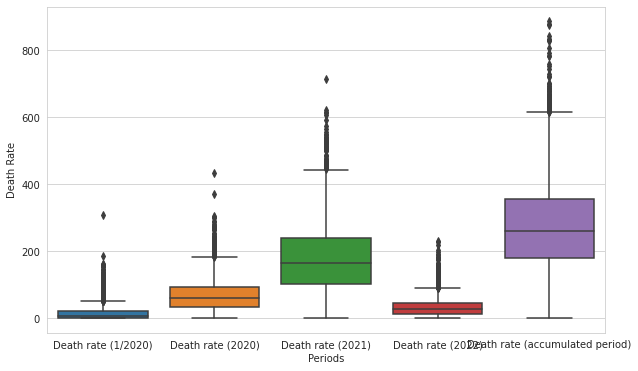

In [43]:
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=df_mortality[['Death rate (1/2020)', 'Death rate (2020)', 'Death rate (2021)', 'Death rate (2022)', 'Death rate (accumulated period)']])

# Customize the plot
plt.ylabel('Death Rate')
plt.xlabel('Periods')

# Show the plot
plt.show()

## Saving data

In [44]:
filename = 'data/output/df_mortality.csv'
df_mortality.to_csv(filename, index=True)

In [45]:
df_mortality

,code_municipality_6,code_municipality_7,population,date,region,deaths,new_deaths,deaths_accumulated_first_semester_2020,delta_first_death_2020-06-30,deaths_accumulated_2020,...,"Death rate (May-June, 2021)","Death rate (July-August, 2021)","Death rate (September-October, 2021)","Death rate (November-December, 2021)","Death rate (January-February, 2022)","Death rate (March-April, 2022)","Death rate (May-June, 2022)","Death rate (July-August, 2022)","Death rate (September-October, 2022)","Death rate (November-December, 2022)"
0,110001,1100015,21495,2022-12-31,North,93.0,0.0,0.0,0.0,16.0,...,55.826936,9.304489,9.304489,23.261224,27.913468,9.304489,4.652245,0.000000,4.652245,4.652245
1,110002,1100023,96833,2022-12-31,North,540.0,0.0,20.0,44.0,122.0,...,77.452934,22.719527,7.228941,29.948468,17.555998,5.163529,0.000000,14.457881,0.000000,1.032706
2,110003,1100031,5363,2022-12-31,North,15.0,0.0,1.0,0.0,4.0,...,74.585120,18.646280,18.646280,0.000000,0.000000,0.000000,18.646280,0.000000,0.000000,0.000000
3,110004,1100049,86895,2022-12-31,North,351.0,0.0,6.0,85.0,60.0,...,84.009437,20.714656,10.357328,19.563841,13.809770,5.754071,1.150814,6.904885,0.000000,1.150814
4,110005,1100056,15890,2022-12-31,North,76.0,0.0,2.0,41.0,8.0,...,69.225928,12.586532,18.879799,12.586532,44.052863,0.000000,6.293266,6.293266,0.000000,6.293266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,522200,5222005,14956,2022-12-31,Midwestern,47.0,0.0,0.0,0.0,7.0,...,66.862798,20.058839,13.372560,0.000000,33.431399,0.000000,6.686280,6.686280,0.000000,6.686280
5566,522205,5222054,8768,2022-12-31,Midwestern,34.0,0.0,1.0,20.0,8.0,...,34.215328,0.000000,0.000000,0.000000,11.405109,0.000000,0.000000,0.000000,0.000000,0.000000
5567,522220,5222203,4215,2022-12-31,Midwestern,7.0,0.0,0.0,0.0,2.0,...,0.000000,0.000000,0.000000,0.000000,23.724792,0.000000,0.000000,23.724792,0.000000,0.000000
5568,522230,5222302,5815,2022-12-31,Midwestern,11.0,0.0,1.0,2.0,3.0,...,17.196905,51.590714,0.000000,0.000000,0.000000,0.000000,0.000000,17.196905,0.000000,0.000000
